# Taiko Fee Mechanism Analysis

This notebook provides an interactive interface for exploring the Taiko fee mechanism analysis.

## Key Research Questions:
1. Can we set μ=0 and rely only on deficit correction?
2. How do different L1 dynamics affect the mechanism?
3. What are optimal parameter ranges for (μ, ν, H)?
4. How do fee caps affect performance?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import our analysis modules
from fee_mechanism_simulator import *
from mechanism_metrics import *
from advanced_mechanisms import *

# Set up plotting
plt.style.use('default')
sns.set_style("whitegrid")
%matplotlib inline

## Quick Start: Single Simulation Example

In [2]:
# Create a simple example simulation

# Parameters
params = SimulationParams(
    mu=0.5,  # Try changing this to 0.0 to test μ=0
    nu=0.3,
    H=144,
    target_balance=1000,
    total_steps=1000
)

# L1 dynamics model
l1_model = GeometricBrownianMotion(mu=0.0, sigma=0.3)

# Run simulation
simulator = TaikoFeeSimulator(params, l1_model)
df = simulator.run_simulation()

print(f"Simulation completed with {len(df)} time steps")
print(f"Average estimated fee: {df['estimated_fee'].mean():.4f} ETH")
print(f"Final vault balance: {df['vault_balance'].iloc[-1]:.2f} ETH")
print(f"Target balance: {params.target_balance} ETH")

Simulation completed with 1000 time steps
Average estimated fee: 0.0001 ETH
Final vault balance: 1011.25 ETH
Target balance: 1000 ETH


## Visualize Simulation Results

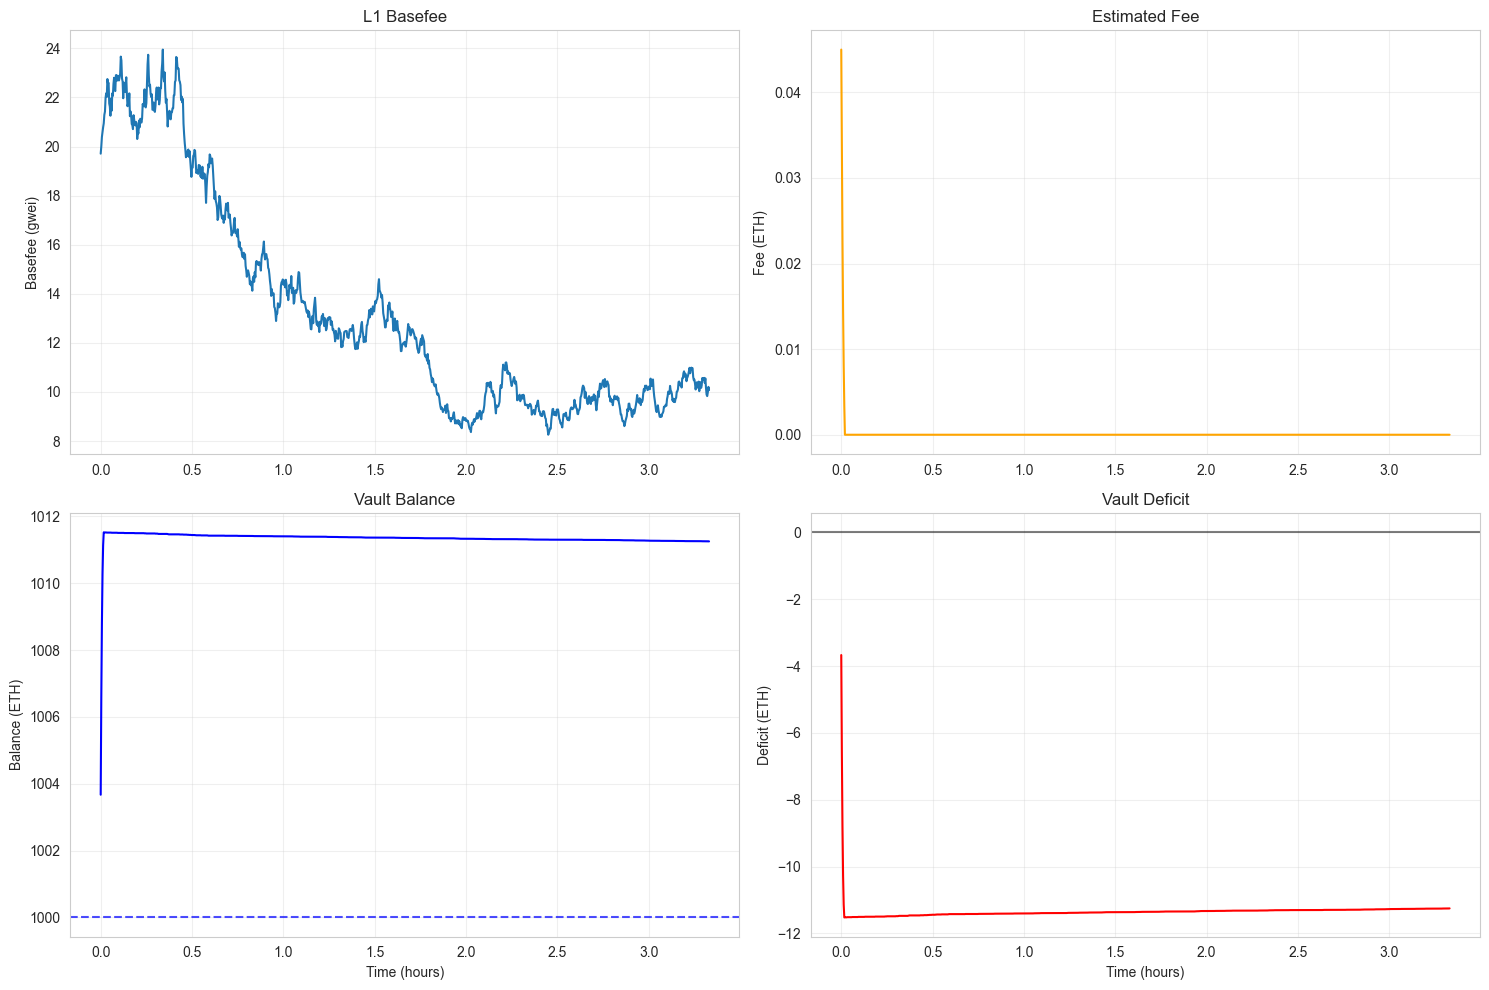

In [3]:
# Create time series plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Convert time steps to hours
time_hours = df['time_step'] * 12 / 3600

# L1 basefee
axes[0,0].plot(time_hours, df['l1_basefee'] / 1e9)
axes[0,0].set_title('L1 Basefee')
axes[0,0].set_ylabel('Basefee (gwei)')
axes[0,0].grid(True, alpha=0.3)

# Estimated fees
axes[0,1].plot(time_hours, df['estimated_fee'], color='orange')
axes[0,1].set_title('Estimated Fee')
axes[0,1].set_ylabel('Fee (ETH)')
axes[0,1].grid(True, alpha=0.3)

# Vault balance
axes[1,0].plot(time_hours, df['vault_balance'], color='blue')
axes[1,0].axhline(y=params.target_balance, color='blue', linestyle='--', alpha=0.7)
axes[1,0].set_title('Vault Balance')
axes[1,0].set_ylabel('Balance (ETH)')
axes[1,0].set_xlabel('Time (hours)')
axes[1,0].grid(True, alpha=0.3)

# Vault deficit
axes[1,1].plot(time_hours, df['vault_deficit'], color='red')
axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1,1].set_title('Vault Deficit')
axes[1,1].set_ylabel('Deficit (ETH)')
axes[1,1].set_xlabel('Time (hours)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Calculate Performance Metrics

In [4]:
# Calculate comprehensive metrics
metrics_calc = MetricsCalculator(target_balance=params.target_balance)
metrics = metrics_calc.calculate_all_metrics(df)

# Display key metrics
print("Performance Metrics:")
print("-" * 30)
print(f"Average Fee: {metrics.avg_fee:.4f} ETH")
print(f"Fee Std Dev: {metrics.fee_std:.4f} ETH")
print(f"Fee CV: {metrics.fee_cv:.3f}")
print(f"95th Percentile Fee: {metrics.fee_95th_percentile:.4f} ETH")
print(f"Time Underfunded: {metrics.time_underfunded_pct:.1f}%")
print(f"Time Overfunded: {metrics.time_overfunded_pct:.1f}%")
print(f"Max Deficit: {metrics.max_deficit:.2f} ETH")
print(f"Insolvency Probability: {metrics.insolvency_probability:.3f}")
print(f"L1 Tracking Error: {metrics.l1_tracking_error:.3f}")

Performance Metrics:
------------------------------
Average Fee: 0.0001 ETH
Fee Std Dev: 0.0020 ETH
Fee CV: 15.588
95th Percentile Fee: 0.0000 ETH
Time Underfunded: 0.0%
Time Overfunded: 100.0%
Max Deficit: -3.67 ETH
Insolvency Probability: 0.000
L1 Tracking Error: 0.227


/Users/ulyssepavloff/Desktop/Nethermind/taiko-fee-analysis/mechanism_metrics.py:214: RuntimeWarning: invalid value encountered in divide
  fee_changes = np.diff(fees) / fees[:-1]


## Compare μ=0 vs μ>0

In [5]:
# Quick comparison of μ=0 vs μ=0.5

mu_values = [0.0, 0.5]
comparison_results = []

for mu in mu_values:
    params_test = SimulationParams(
        mu=mu, nu=0.3, H=144, target_balance=1000, total_steps=500
    )
    
    simulator_test = TaikoFeeSimulator(params_test, l1_model)
    df_test = simulator_test.run_simulation()
    
    metrics_test = metrics_calc.calculate_all_metrics(df_test)
    
    comparison_results.append({
        'mu': mu,
        'avg_fee': metrics_test.avg_fee,
        'fee_cv': metrics_test.fee_cv,
        'time_underfunded_pct': metrics_test.time_underfunded_pct,
        'max_deficit': metrics_test.max_deficit
    })

comparison_df = pd.DataFrame(comparison_results)
print("μ=0 vs μ>0 Comparison:")
print(comparison_df)

μ=0 vs μ>0 Comparison:
    mu   avg_fee     fee_cv  time_underfunded_pct  max_deficit
0  0.0  0.000003   1.042658                  99.8     0.007536
1  0.5  0.000239  11.352807                   0.0    -3.888767


/Users/ulyssepavloff/Desktop/Nethermind/taiko-fee-analysis/mechanism_metrics.py:214: RuntimeWarning: divide by zero encountered in divide
  fee_changes = np.diff(fees) / fees[:-1]
/Users/ulyssepavloff/Desktop/Nethermind/taiko-fee-analysis/mechanism_metrics.py:214: RuntimeWarning: invalid value encountered in divide
  fee_changes = np.diff(fees) / fees[:-1]
/Users/ulyssepavloff/Desktop/Nethermind/taiko-fee-analysis/mechanism_metrics.py:214: RuntimeWarning: invalid value encountered in divide
  fee_changes = np.diff(fees) / fees[:-1]


## Test Different L1 Scenarios

In [6]:
# Test mechanism under different L1 dynamics

l1_scenarios = [
    ("Low Volatility", GeometricBrownianMotion(mu=0.0, sigma=0.1)),
    ("Medium Volatility", GeometricBrownianMotion(mu=0.0, sigma=0.3)),
    ("High Volatility", GeometricBrownianMotion(mu=0.0, sigma=0.6)),
    ("Regime Switching", RegimeSwitchingModel()),
    ("Spike Events", SpikeEventsModel(
        GeometricBrownianMotion(mu=0.0, sigma=0.2), spike_probability=0.005
    ))
]

scenario_results = []

base_params = SimulationParams(mu=0.5, nu=0.3, H=144, target_balance=1000, total_steps=500)

for scenario_name, l1_model_test in l1_scenarios:
    simulator_scenario = TaikoFeeSimulator(base_params, l1_model_test)
    df_scenario = simulator_scenario.run_simulation()
    metrics_scenario = metrics_calc.calculate_all_metrics(df_scenario)
    
    scenario_results.append({
        'scenario': scenario_name,
        'avg_fee': metrics_scenario.avg_fee,
        'fee_cv': metrics_scenario.fee_cv,
        'time_underfunded_pct': metrics_scenario.time_underfunded_pct
    })

scenario_df = pd.DataFrame(scenario_results)
print("L1 Scenario Comparison:")
print(scenario_df)

L1 Scenario Comparison:
            scenario   avg_fee     fee_cv  time_underfunded_pct
0     Low Volatility  0.000258  10.869789                   0.0
1  Medium Volatility  0.000230  11.484440                   0.0
2    High Volatility  0.000240  11.273692                   0.0
3   Regime Switching  0.000238  11.304823                   0.0
4       Spike Events  0.000236  11.423409                   0.0


/Users/ulyssepavloff/Desktop/Nethermind/taiko-fee-analysis/mechanism_metrics.py:214: RuntimeWarning: invalid value encountered in divide
  fee_changes = np.diff(fees) / fees[:-1]
/Users/ulyssepavloff/Desktop/Nethermind/taiko-fee-analysis/mechanism_metrics.py:214: RuntimeWarning: invalid value encountered in divide
  fee_changes = np.diff(fees) / fees[:-1]
/Users/ulyssepavloff/Desktop/Nethermind/taiko-fee-analysis/mechanism_metrics.py:214: RuntimeWarning: invalid value encountered in divide
  fee_changes = np.diff(fees) / fees[:-1]
/Users/ulyssepavloff/Desktop/Nethermind/taiko-fee-analysis/mechanism_metrics.py:214: RuntimeWarning: invalid value encountered in divide
  fee_changes = np.diff(fees) / fees[:-1]
/Users/ulyssepavloff/Desktop/Nethermind/taiko-fee-analysis/mechanism_metrics.py:214: RuntimeWarning: invalid value encountered in divide
  fee_changes = np.diff(fees) / fees[:-1]


## Interactive Parameter Explorer

Use the widgets below to explore how different parameters affect the mechanism:

In [7]:
# Install ipywidgets if not available: pip install ipywidgets
try:
    from ipywidgets import interact, FloatSlider, IntSlider
    
    def explore_parameters(mu=0.5, nu=0.3, H=144, elasticity=0.2):
        params_explore = SimulationParams(
            mu=mu, nu=nu, H=int(H), fee_elasticity=elasticity,
            target_balance=1000, total_steps=300  # Shorter for interactivity
        )
        
        l1_explore = GeometricBrownianMotion(mu=0.0, sigma=0.3)
        simulator_explore = TaikoFeeSimulator(params_explore, l1_explore)
        df_explore = simulator_explore.run_simulation()
        
        metrics_explore = metrics_calc.calculate_all_metrics(df_explore)
        
        print(f"μ={mu:.2f}, ν={nu:.2f}, H={int(H)}, elasticity={elasticity:.2f}")
        print(f"Average Fee: {metrics_explore.avg_fee:.4f} ETH")
        print(f"Fee CV: {metrics_explore.fee_cv:.3f}")
        print(f"Time Underfunded: {metrics_explore.time_underfunded_pct:.1f}%")
        
        # Quick plot
        plt.figure(figsize=(12, 4))
        time_hours = df_explore['time_step'] * 12 / 3600
        
        plt.subplot(1, 2, 1)
        plt.plot(time_hours, df_explore['estimated_fee'])
        plt.title('Estimated Fee')
        plt.ylabel('Fee (ETH)')
        plt.xlabel('Time (hours)')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(time_hours, df_explore['vault_deficit'])
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.title('Vault Deficit')
        plt.ylabel('Deficit (ETH)')
        plt.xlabel('Time (hours)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Create interactive widgets
    interact(explore_parameters,
             mu=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description='μ'),
             nu=FloatSlider(value=0.3, min=0.1, max=0.9, step=0.1, description='ν'),
             H=IntSlider(value=144, min=24, max=576, step=24, description='H'),
             elasticity=FloatSlider(value=0.2, min=0.0, max=1.0, step=0.1, description='Elasticity'))
             
except ImportError:
    print("Install ipywidgets for interactive exploration: pip install ipywidgets")
    print("Then restart the kernel and run this cell again.")

interactive(children=(FloatSlider(value=0.5, description='μ', max=1.0), FloatSlider(value=0.3, description='ν'…